# NLP Disaster tweets project

The goal of this project is to predict if a tweet describes a real disaster or not. The evaluation metric is the f1 score which balances precision and recall. My approach was to keep the pipeline small, readable and easy to reproduce

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Problem and data

This project predicts if a tweet is about a real disaster or not. The dataset is Kaggles “Natural Language Processing with Disaster Tweets” competition data. The training data has 7,613 rows with columns id, text, keyword, location and target. The test data has 3263 rows with the columns id, text, keyword and location. The label we predict is the target column in the training set. The evaluation metric is the f1 score which balances precision and recall

In [14]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

candfilpath = sorted(glob.glob("/kaggle/input/**/train.csv", recursive=True))
trainpath = candfilpath[0]
tstpath = trainpath.replace("train.csv", "test.csv")

traindat = pd.read_csv(trainpath)
testdat = pd.read_csv(tstpath)

print(traindat.shape, testdat.shape)
print(traindat.head(2)[["id","text","target"]])

(7613, 5) (3263, 4)
   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1


## EDA, cleaning and plan

I started by checking the class balance and the distribution of tweet lengths to understand the data. The class with label 0 is slightly larger and most tweets are short. I cleaned the text by lowercasing, removing urls and punctuation and removing extra spaces. This keeps important words while reducing noise. My plan was to build a strong baseline using tf-idf with bigrams and logistic regression. I also built small GRU model to meet the sequential neural network requirement. I compared validation f1 for both models

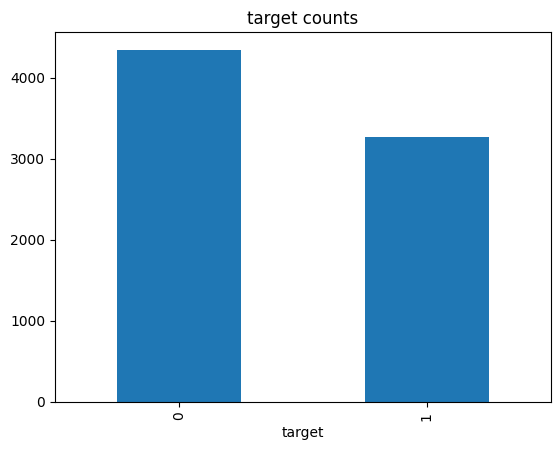

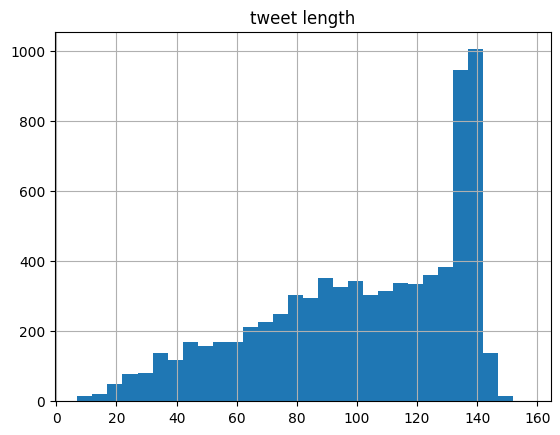

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   

                                               clean  target  
0  our deeds are the reason of this earthquake ma...       1  
1              forest fire near la ronge sask canada       1  
2  all residents asked to shelter in place are be...       1  


In [15]:
# check class balance and tweet length
# clean lowercase remove urls and punctuation and fix space
traindat["target"].value_counts().plot(kind="bar", title="target counts")
plt.show()

traindat["len"] = traindat["text"].str.len()
traindat["len"].hist(bins=30)
plt.title("tweet length")
plt.show()

def mrclean(s):
    s = str(s).lower()
    s = re.sub(r"http\S+", "", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

traindat["clean"] = traindat["text"].apply(mrclean)
testdat["clean"] = testdat["text"].apply(mrclean)

print(traindat[["text","clean","target"]].head(3))

## Model choices and text

I converted text in to numbers two ways. For the baseline, I used tf-idf which created weighted word features and reduced the impact of very common words. For the GRU, I use a Keras embedding layer which learned a compact vector for each token.
Logistic regression with tf-idf worked well on short text and bigram captured short phrases. The small GRU read tokens in order and captured simple sequence patterns. I used an 80/20 split for validation to get an estimate.
For logistic regression, I set a maximum of 200 iterations. For the GRU, I used embedding (20k, 32) followed by GRU(32) and a sigmoid output with a sequence length of 40 for three epochs using Adam

In [16]:
# baseline: tf-idf logistic regression
# turn text into tf-idf features (unigrams + bigrams)
# split data into train/validation
# train a simple log reg and print validation 
# then train on all data 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

traintxt, valtxt, trainlab, vallab = train_test_split(traindat["clean"], traindat["target"], test_size=0.2, random_state=0, stratify=traindat["target"])

tfvect = TfidfVectorizer(min_df=2, ngram_range=(1,2))
xtrain = tfvect.fit_transform(traintxt)
xval = tfvect.transform(valtxt)

logreg = LogisticRegression(max_iter=200)
logreg.fit(xtrain, trainlab)
valpredlr = logreg.predict(xval)
print("valid F1 (TFIDF+LR):", f1_score(vallab, valpredlr))

# train on all
tfvectall = TfidfVectorizer(min_df=2, ngram_range=(1,2))
X_full = tfvectall.fit_transform(traindat["clean"])
logregall = LogisticRegression(max_iter=200)
logregall.fit(X_full, traindat["target"])
testpred = logregall.predict(tfvectall.transform(testdat["clean"]))

subdatlr = pd.DataFrame({"id": testdat["id"], "target": testpred})
subdatlr.to_csv("submission_lr.csv", index=False)
print(subdatlr.head())

valid F1 (TFIDF+LR): 0.7516891891891893
   id  target
0   0       1
1   2       0
2   3       1
3   9       0
4  11       1


## Baseline results

The tf-idf and logistic regression model reached a validation f1 of about .75. Bigrams and cleaning are sufficient to produce a strong baseline

In [17]:
# gru(sequential)
# very small GRU model
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

ktok = Tokenizer(num_words=20000, oov_token="<unk>")
ktok.fit_on_texts(traindat["clean"].tolist())
trainseq = ktok.texts_to_sequences(traindat["clean"].tolist())
testseq = ktok.texts_to_sequences(testdat["clean"].tolist())

maxleng = 40
trainpad = pad_sequences(trainseq, maxlen=maxleng)
testpad = pad_sequences(testseq,  maxlen=maxleng)
y = traindat["target"].values

trainvalgru, valgru, trainlabvec, xlabvec = train_test_split(trainpad, y, test_size=0.2, random_state=0, stratify=y)

grumodel = keras.Sequential([keras.layers.Embedding(input_dim=20000, output_dim=32, input_length=maxleng),keras.layers.GRU(32),keras.layers.Dense(1, activation="sigmoid")])
grumodel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
grumodel.fit(trainvalgru, trainlabvec, epochs=3, batch_size=64, validation_data=(valgru, xlabvec), verbose=1)

valpredgru = (grumodel.predict(valgru) > 0.5).astype(int).ravel()
print("valid F1 (GRU):", f1_score(xlabvec, valpredgru))

# train on all
gruall = keras.models.clone_model(grumodel)
gruall.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
gruall.fit(trainpad, y, epochs=3, batch_size=64, verbose=1)

subdatgru = pd.DataFrame({"id": testdat["id"],"target": (gruall.predict(testpad) > 0.5).astype(int).ravel()})
subdatgru.to_csv("submission_gru.csv", index=False)
print(subdatgru.head())

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5570 - loss: 0.6757 - val_accuracy: 0.7735 - val_loss: 0.4977
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8371 - loss: 0.3963 - val_accuracy: 0.8043 - val_loss: 0.4583
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9185 - loss: 0.2222 - val_accuracy: 0.7879 - val_loss: 0.5394
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
valid F1 (GRU): 0.7462686567164181
Epoch 1/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5760 - loss: 0.6622
Epoch 2/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8481 - loss: 0.3697
Epoch 3/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9167 - loss: 0.2279
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


## GRU results

The small GRU model reached a validation f1 of about 0.74. Logistic regression performed better than the GRU. The GRU would benefit from longer sequences or extra epochs


## Conclusion

The simple tf-idf with logistic regression baseline performed best for this dataset and the GRU provided a useful sequence baseline. If I continued to work on this, I would consider slightly longer sequences